<a href="https://colab.research.google.com/github/fanqingsong/code_snippet/blob/master/%E2%80%9Cfcc_predict_health_costs_with_regression_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

# 新段落

In [2]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.layers.experimental.preprocessing as preprocessing

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 28.7MB/s 


In [3]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-05-09 08:10:42--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0s      

2021-05-09 08:10:42 (106 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [4]:
using_dataset = dataset.copy()
print(using_dataset.isna().sum())
labels = using_dataset.pop("expenses")
print(labels.tail())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: expenses, dtype: float64


In [5]:
features = using_dataset
print(features.tail())

      age     sex   bmi  children smoker     region
1333   50    male  31.0         3     no  northwest
1334   18  female  31.9         0     no  northeast
1335   18  female  36.9         0     no  southeast
1336   21  female  25.8         0     no  southwest
1337   61  female  29.1         0    yes  northwest


In [80]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
test_dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1305,24,female,27.7,0,no,southeast,2464.62
1315,18,male,28.3,1,no,northeast,11272.33
1318,35,male,39.7,4,no,northeast,19496.72
1326,42,female,32.9,0,no,northeast,7050.02
1333,50,male,31.0,3,no,northwest,10600.55


In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('expenses')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [10]:
batch_size = 5
train_ds = df_to_dataset(train_dataset, batch_size=batch_size)

In [62]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )


Every feature: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
A batch of ages: tf.Tensor(
[54 30 51 19 30 23 19 19 19 20 51 19 21 25 40 51 27 48 18 50 39 24 52 31
 42 19 64 60 49 19 56 47 23 52 18 29 60 21 37 64 59 47 53 34 19 52 50 44
 22 41 35 38 45 50 60 19 39 41 59 23 21 27 29 46 50 22 18 25 18 21 24 48
 29 27 20 61 57 43 64 34 39 26 55 30 43 33 60 26 46 57 56 64 61 40 55 22
 62 57 21 18 45 21 58 20 24 49 21 63 64 48 51 57 34 40 34 31 62 50 19 57
 27 19 31 56 57 44 35 18 58 64 28 49 18 52 63 54 25 24 29 64 35 32 51 32
 46 41 34 19 33 54 62 22 56 63 48 54 37 33 38 43 54 49 58 55 47 58 45 38
 41 45 34 31 47 47 36 57 23 40 26 52 31 45 39 43 27 18 43 49 19 53 53 49
 33 43 24 36 48 18 21 35 28 27 57 51 56 25 19 62 37 38 53 19 22 19 55 20
 54 26 20 39 25 23 47 34 53 33 46 52 61 44 51 47 23 57 41 27 49 33 38 37
 20 23 41 61 37 19 31 24 62 48 50 22 52 23 59 45], shape=(256,), dtype=int64)
A batch of targets: tf.Tensor(
[25382.3   4149.74 47462.89 22493.66 17361.77  1826.84 18838.7  

In [13]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [18]:
photo_count_col = train_features['age']
layer = get_normalization_layer('age', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.07332239],
       [-1.4881986 ],
       [-0.28555384],
       [ 1.3415539 ],
       [-1.4881986 ]], dtype=float32)>

In [45]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [46]:
type_col = train_features['sex']
layer = get_category_encoding_layer('sex', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [81]:
batch_size = 256
train_ds = df_to_dataset(train_dataset, batch_size=batch_size)
test_ds = df_to_dataset(test_dataset, shuffle=False, batch_size=batch_size)

In [51]:
CATEGORICAL_COLUMNS = ['sex', 'smoker', 'region']
NUMERIC_COLUMNS = ['age', 'bmi', 'children']

all_inputs = []
encoded_features = []

# Numeric features.
for header in NUMERIC_COLUMNS:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [52]:
# Categorical features encoded as string.
for header in CATEGORICAL_COLUMNS:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string', max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [39]:
print(all_inputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bmi')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'children')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'smoker')>, <KerasTensor: shape=(None, 1) dtype=string (created by layer 'region')>]


In [40]:
print(encoded_features)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>, <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_9')>]


In [41]:
all_features = tf.keras.layers.concatenate(encoded_features)
print(all_features)


KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")


In [112]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
              loss="mse",
              metrics=["mae"])

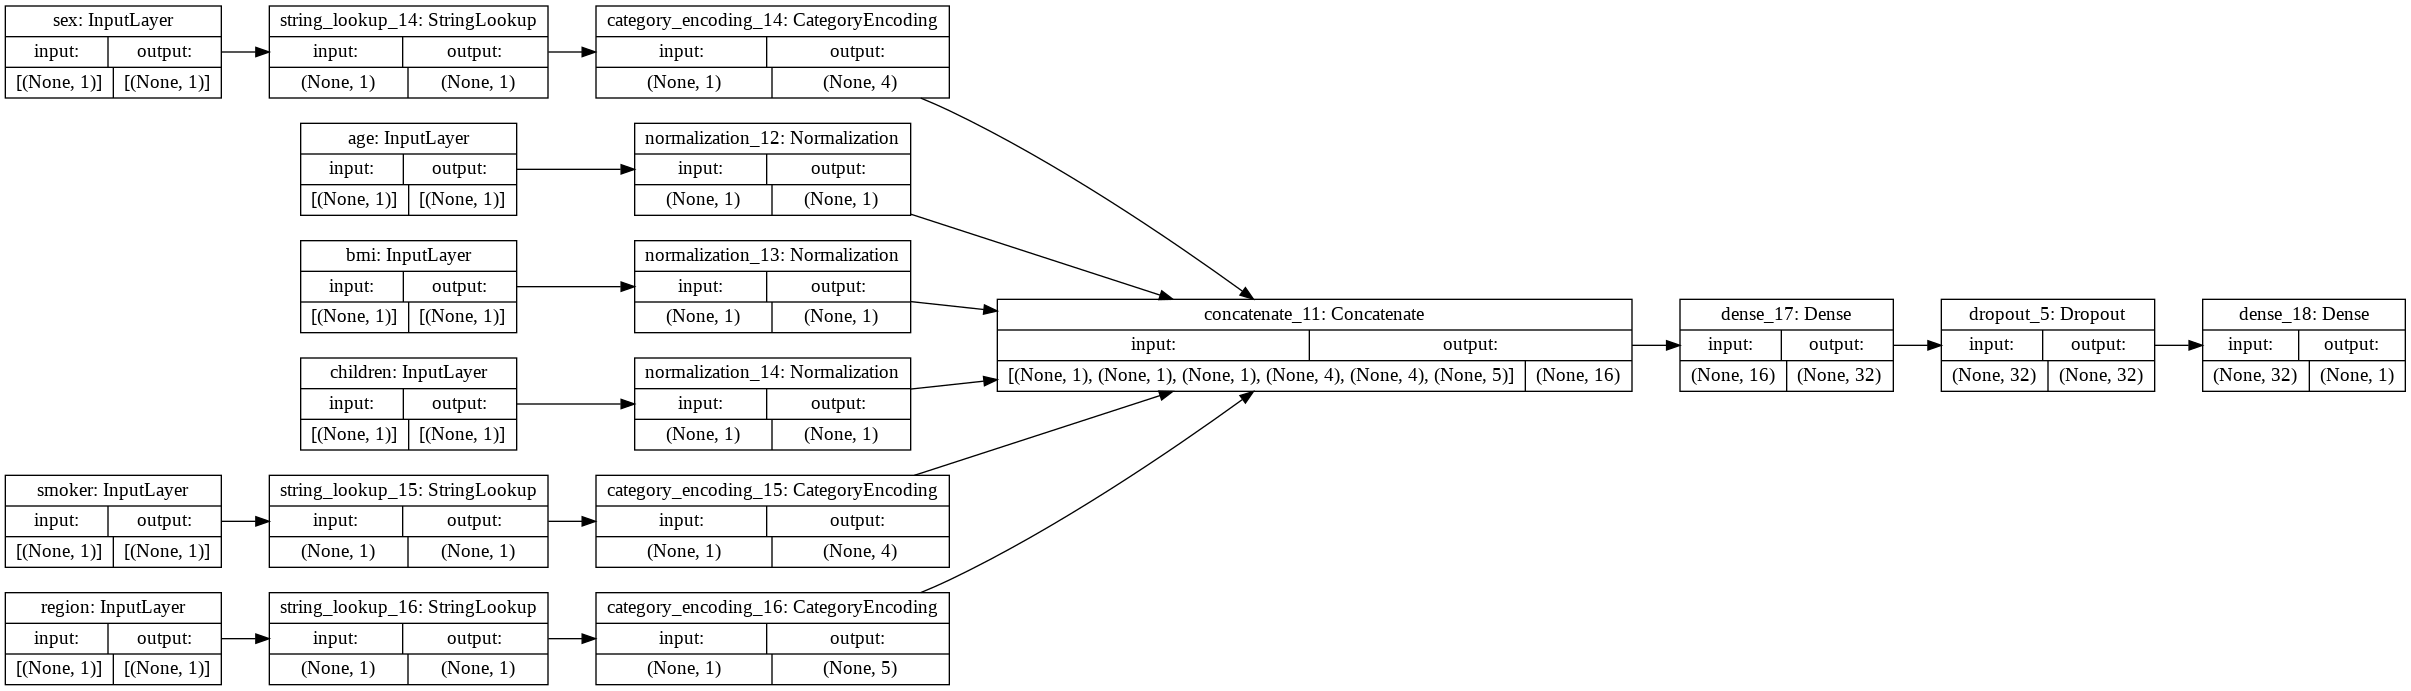

In [108]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [65]:
# train_ds_x = train_ds.map(lambda x, y : x)
# train_ds_y = train_ds.map(lambda x, y : y)

# print(train_ds_x)
# print(train_ds_y)

In [114]:

model.fit(train_ds, epochs=100)


Epoch 1/100
5/5 [==============================] - 0s 5ms/step - loss: 68478544.0000 - mae: 5967.4658
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 61681408.0000 - mae: 5753.2739
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 55592684.0000 - mae: 5497.8623
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 54500940.0000 - mae: 5415.4136
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 49746108.0000 - mae: 5167.4917
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 46726852.0000 - mae: 4872.6431
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 44282788.0000 - mae: 4649.1504
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 40770040.0000 - mae: 4362.0566
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 39009904.0000 - mae: 4316.6724
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 39327672.0

In [115]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 8ms/step - loss: 33786660.0000 - mae: 3359.9141
Accuracy 3359.9140625


In [116]:

test_features = test_ds.map(lambda x, y: x)
test_features = test_features.as_numpy_iterator()
test_features = list(test_features)[0]
# print(len(test_features))
# print(test_features)

test_labels = test_ds.map(lambda x, y: y)
test_labels = test_labels.as_numpy_iterator()
test_labels = list(test_labels)[0]
# print(len(test_labels))
# print(test_labels)


8/8 - 0s - loss: 30399724.0000 - mae: 3241.5977
Testing set Mean Abs Error: 3241.60 expenses
You passed the challenge. Great job!


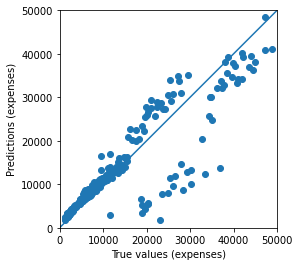

In [117]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae = model.evaluate(test_features, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
